### Necessary Packages

In [1]:
import torch
import numpy as np
import sys
import dotenv
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../..')
from src.models import ResNet34
from torchsummary import summary
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose,ToTensor
from src.transforms import LabelMapper
from src.utils import load_model_from_folder,load_history_from_folder,predict,create_df,make_metric,compute_metrics
from src.datasets import RoIDataset
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score,precision_score


Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/projet/.env.


**Model Hyperparameters :**

- Initial weights : Image Net.
- batch size : 128
- epochs : 20
- learning rate : 0.001
- sampler : random
- decay rate : no learning rate decay
- dropout : no dropout
- optimizer : adam
- weight decay : no weight decay
- Depth (number of convolutional blocks to fine tune) : 2

### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Results reproducibility

In [3]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

### Load envirement variables

In [4]:
PATCHES_DIR = dotenv.get_key(dotenv.find_dotenv(), "PATCHES_DIR")
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "MODELS_DIR")
HISTORIES_DIR = dotenv.get_key(dotenv.find_dotenv(), "HISTORIES_DIR")

In [5]:
TRAIN_DIR = os.path.join(PATCHES_DIR, "train")
VAL_DIR = os.path.join(PATCHES_DIR, "val")
TEST_DIR = os.path.join(PATCHES_DIR, "test")

In [6]:
print(MODELS_DIR)
print(PATCHES_DIR)
print(HISTORIES_DIR)
print(TRAIN_DIR)
print(VAL_DIR)
print(TEST_DIR)

/home/abdelnour/Documents/4eme_anne/S2/projet/models
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched
/home/abdelnour/Documents/4eme_anne/S2/projet/histories
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/train
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/val
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/test


### Global

In [7]:
BATCH_SIZE = 512
NUM_WORKERS = 6
PREFETCH_FACTOR = 2
WEIGHTS_FOLDER  = os.path.join(MODELS_DIR, "resnet34")
HISTORIES_FOLDER = path = os.path.join(HISTORIES_DIR, "resnet34")

### Load the model

In [8]:
model = ResNet34(n_classes=3).to(device)

In [9]:
load_model_from_folder(model, WEIGHTS_FOLDER, verbose=True)

loading weights with name : 1710633143.106203.pt


In [10]:
summary(model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Learning graph

In [11]:
history_df = load_history_from_folder(HISTORIES_FOLDER)

<Axes: xlabel='epoch', ylabel='accuracy'>

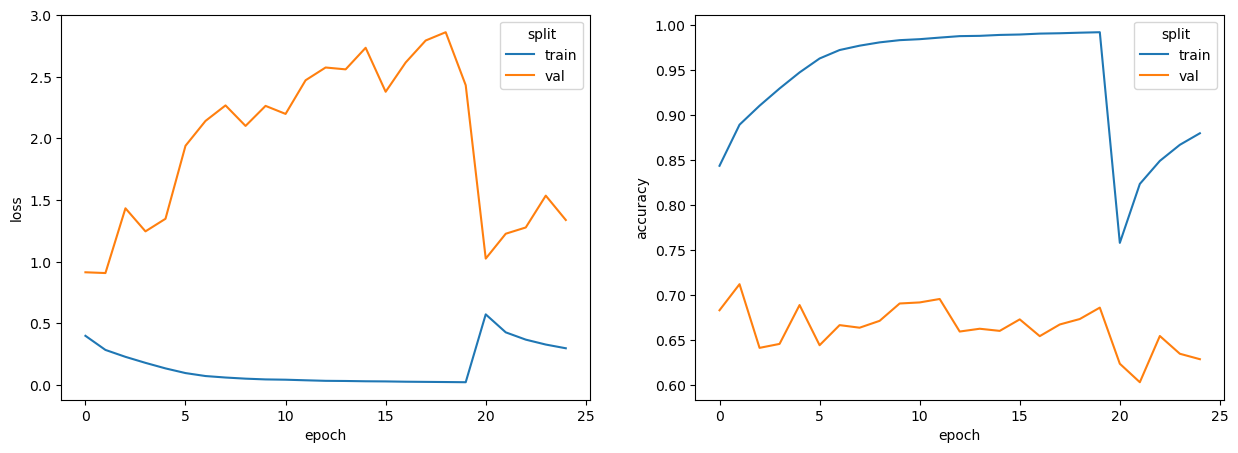

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

fig.set_size_inches(15, 5)

sns.lineplot(data=history_df, x="epoch", y="loss", hue="split", ax=ax1)
sns.lineplot(data=history_df, x="epoch", y="accuracy", hue="split", ax=ax2)

### Data Loading

In [13]:
label_mapper = LabelMapper({
    0:0, # 0 is the label for benign (BY)
    1:0, 
    2:0,
    3:1, # 1 is the label for atypical (AT)
    4:1,
    5:2, # 2 is the label for malignant (MT)
    6:2,
})

In [14]:
dataset = RoIDataset(
    root=TEST_DIR,
    target_transform=label_mapper,
    transform=Compose([
        ToTensor(),
    ]),
)

In [15]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

### Prediciting

In [16]:
paths,y_hat,y = predict(model, loader, device=device)

  0%|          | 0/78 [00:00<?, ?it/s]

In [17]:
df = create_df(paths,y, y_hat)

In [18]:
df.head()

,patch_name,label,roi,benign,atypical,malignant,predicted_label
0,BRACS_1286_N_40_0.png,0,BRACS_1286_N_40.png,0.784392,6.764493e-08,0.215608,0
1,BRACS_1286_N_40_1.png,0,BRACS_1286_N_40.png,0.000031,8.468672e-09,0.999969,2
2,BRACS_1286_N_40_10.png,0,BRACS_1286_N_40.png,0.772002,6.388880e-05,0.227934,0
3,BRACS_1286_N_40_11.png,0,BRACS_1286_N_40.png,0.005589,1.000129e-02,0.984409,2
4,BRACS_1286_N_40_12.png,0,BRACS_1286_N_40.png,0.000019,1.740806e-04,0.999807,2


### Predictions analysis (patches persepective)

In [19]:
metrics= {
    "accuracy" : accuracy_score,
    "precision_macro" : make_metric(precision_score, average="macro"),
    "precision_micro" : make_metric(precision_score, average="micro"),
    "recall_macro" : make_metric(recall_score, average="macro"),
    "recall_micro" : make_metric(recall_score, average="micro"),
    "f1_macro" : make_metric(f1_score, average="macro"),
    "f1_micro" : make_metric(f1_score, average="micro")
}

In [20]:
compute_metrics(metrics, df["label"], df["predicted_label"])

accuracy           0.555475
precision_macro    0.460956
precision_micro    0.555475
recall_macro       0.405130
recall_micro       0.555475
f1_macro           0.382770
f1_micro           0.555475
dtype: float64

<Axes: >

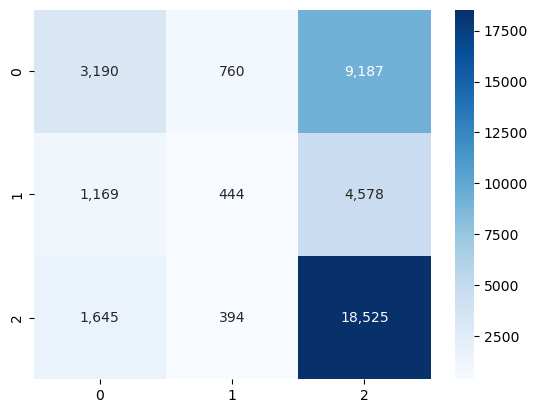

In [21]:
cm = confusion_matrix(df["label"], df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, softvoting)

In [22]:
soft_df = df[["label","roi","benign","atypical","malignant"]] \
    .groupby(by=["label","roi"]) \
    .mean() \
    .reset_index()

In [23]:
soft_df.head()

,label,roi,benign,atypical,malignant
0,0,BRACS_1228_UDH_2.png,0.250216,0.385178,0.364607
1,0,BRACS_1284_UDH_4.png,0.584338,0.007641,0.408021
2,0,BRACS_1286_N_40.png,0.122851,0.065163,0.811985
3,0,BRACS_1286_PB_21.png,0.153775,0.026816,0.819409
4,0,BRACS_1286_PB_5.png,0.120563,0.003455,0.875982


In [24]:
soft_df["predicted_label"] = np.argmax(soft_df[['benign','atypical','malignant']].values, axis=1)

In [25]:
soft_df.head()

,label,roi,benign,atypical,malignant,predicted_label
0,0,BRACS_1228_UDH_2.png,0.250216,0.385178,0.364607,1
1,0,BRACS_1284_UDH_4.png,0.584338,0.007641,0.408021,0
2,0,BRACS_1286_N_40.png,0.122851,0.065163,0.811985,2
3,0,BRACS_1286_PB_21.png,0.153775,0.026816,0.819409,2
4,0,BRACS_1286_PB_5.png,0.120563,0.003455,0.875982,2


In [26]:
compute_metrics(metrics, soft_df["label"], soft_df["predicted_label"])

accuracy           0.340351
precision_macro    0.442843
precision_micro    0.340351
recall_macro       0.370689
recall_micro       0.340351
f1_macro           0.231997
f1_micro           0.340351
dtype: float64

<Axes: >

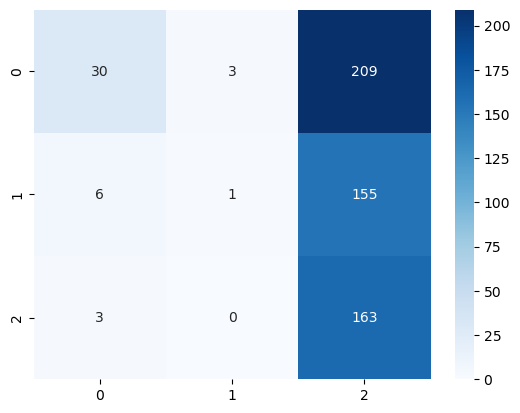

In [27]:
cm = confusion_matrix(soft_df["label"], soft_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, hardvoting)

In [28]:
def count(x:np.ndarray) -> float:
    values, counts = np.unique(x, return_counts=True)
    return values[counts.argmax()]


In [29]:
hard_df = df[["label","roi","predicted_label"]] \
    .groupby(by=["label","roi"]) \
    .agg(count) \
    .reset_index()

In [30]:
hard_df.head()

,label,roi,predicted_label
0,0,BRACS_1228_UDH_2.png,1
1,0,BRACS_1284_UDH_4.png,0
2,0,BRACS_1286_N_40.png,2
3,0,BRACS_1286_PB_21.png,2
4,0,BRACS_1286_PB_5.png,2


In [31]:
compute_metrics(metrics, hard_df["label"], hard_df["predicted_label"])

accuracy           0.340351
precision_macro    0.421753
precision_micro    0.340351
recall_macro       0.370059
recall_micro       0.340351
f1_macro           0.233541
f1_micro           0.340351
dtype: float64

<Axes: >

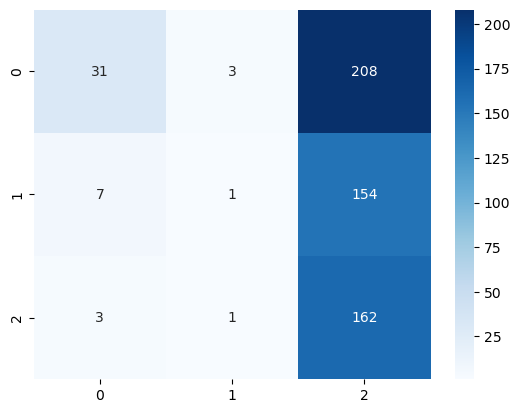

In [32]:
cm = confusion_matrix(hard_df["label"], hard_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')